## Zaman Serisi Çalışması
Adidas firmasına ait bir mağazanın satış miktarları veri seti

In [1]:
#kütüphaneleri içe aktar
import pandas as pd

In [2]:
#veri setini yükle
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ECS_VeriBilimi_25H/adidas-quarterly-sales.csv")

In [3]:
df.head()

,Time Period,Revenue
0,2000Q1,1517
1,2000Q2,1248
2,2000Q3,1677
3,2000Q4,1393
4,2001Q1,1558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time Period  88 non-null     object
 1   Revenue      88 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


In [5]:
df.index=pd.PeriodIndex(df['Time Period'],freq='Q').to_timestamp()
df.drop(columns=["Time Period"], inplace=True)

In [6]:
df

,Revenue
Time Period,
2000-01-01,1517
2000-04-01,1248
2000-07-01,1677
2000-10-01,1393
2001-01-01,1558
...,...
2020-10-01,5142
2021-01-01,5268
2021-04-01,5077


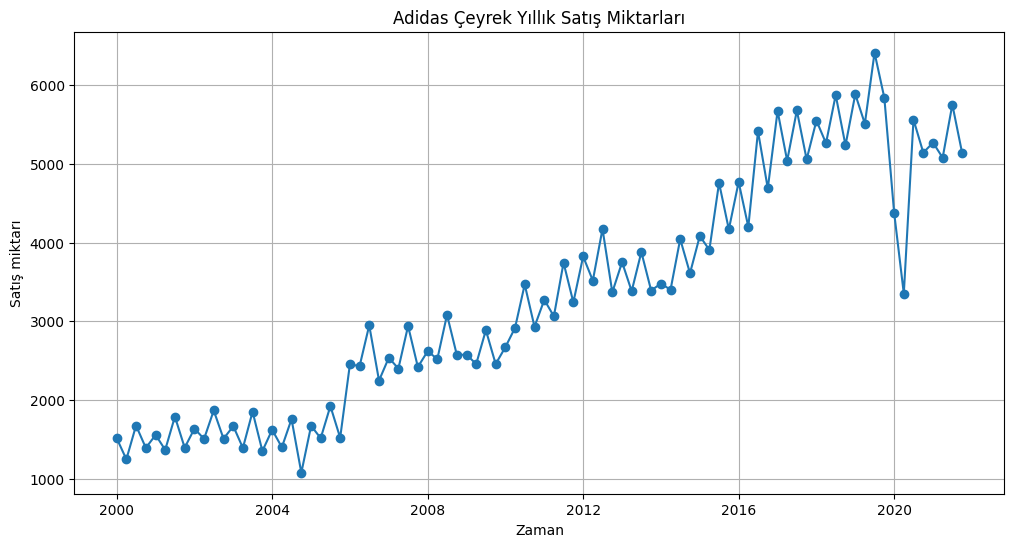

In [7]:
#trend ve mevsimsellik var mı?
import matplotlib.pyplot as plt

# grafik boyutunu ayarla
plt.figure(figsize=(12, 6))

#Zaman serisini çiz
plt.plot(df.index,df['Revenue'], marker="o")

plt.title("Adidas Çeyrek Yıllık Satış Miktarları")
plt.xlabel('Zaman')
plt.ylabel('Satış miktarı')
plt.grid(True)
plt.show()

In [8]:
#STL decomposition sezon, trend ve artık bileşeneri inceleme
from statsmodels.tsa.seasonal import STL

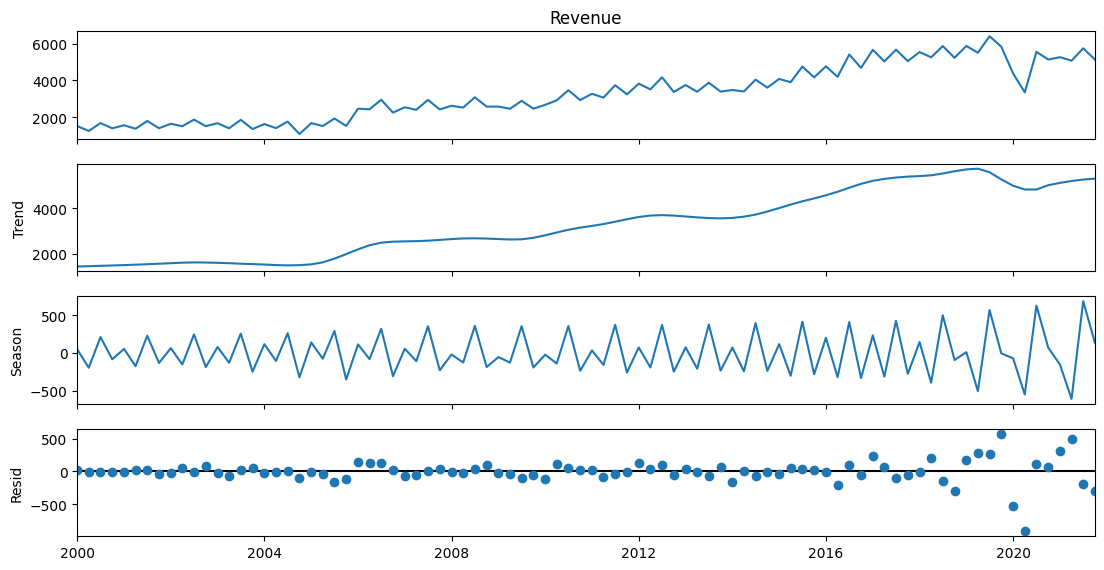

In [9]:
stl=STL(df['Revenue'],period=4)
result=stl.fit()

#sonuçları çizdir
fig=result.plot()
fig.set_size_inches(12,6)
plt.show()

Trend: Orta uzun vadede genel bir artış eğilimi görülmektedir.

Sezonluk etki bariz şekilde görülmektedir. Özellikle 3. çeyrek tavan olarak öne çıkmaktadır.

Residual: Düzensizlikler ortalama etrafında dağılmaktadır.

Global krizlerin etkisi de görülmektedir.


In [10]:
from statsmodels.tsa.stattools import adfuller
#Modellemeye hazır mı Durağanlık testi ARIMA-SARIMA için zaman serisi analiz modeleri hazır mı ?
# trend ve mevsimsellik olduğu için diff fonksiyonu ile durağan olmama durumu ortadan kaldırılmalı her değer bir öncekinden çıkarılmalı
df['Revenue_diff']=df['Revenue'].diff().dropna()

#birnci farklı seride ADF durağanlık testi
adf_result_diff=adfuller(df['Revenue_diff'].dropna())

#Sonuçları düzenli gösterme
adf_output_diff={'ADF İstatistik':adf_result_diff[0],
                 'p-değeri':adf_result_diff[1],
                 'Kritik değerler':adf_result_diff[4]}
adf_output_diff

{'ADF İstatistik': np.float64(-4.3784483201342725),
 'p-değeri': np.float64(0.00032401497959918233),
 'Kritik değerler': {'1%': np.float64(-3.5148692050781247),
  '5%': np.float64(-2.8984085156250003),
  '10%': np.float64(-2.58643890625)}}

In [ ]:
#p<.5 olduğu için seri durağan hale gelmiştir. ARIMA ve SARIMA için hazır.
#d=1 parametresini vermeliyiz

In [11]:
#SARIMA Model oluştur
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(
    df['Revenue'],
    order=(1,1,1), #p,d,q parametreleri
    seasonal_order=(1,1,1,4), #p, mevsimsellik, d, q,
    enforce_stationarity=False,
    enforce_invertibility=False #False olunca durağanlık zorunluluğu yoktur, optimizasyon daha esnek çalışır
)


order: Trend bileşeni için ARIMA parametreleri.

seasonal_order: Tekrarlayan sezonluk desenler için ek ARIMA parametreleri.

In [12]:
#modeli eğit
sarima_result=model.fit(disp=False)

In [13]:
#Tahminler
df['Forecast']=sarima_result.fittedvalues

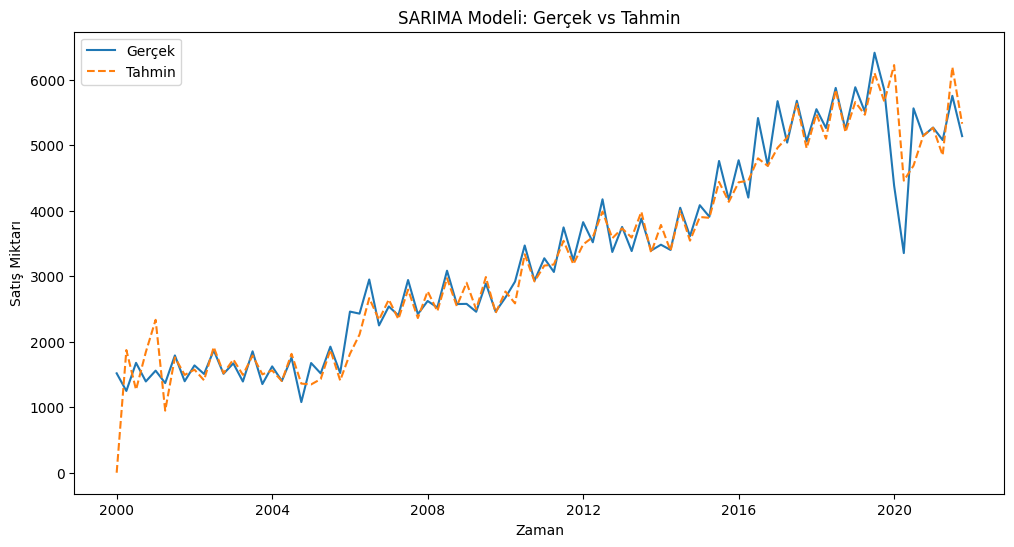

In [15]:
# Gerçek ve taminleri karşılaştır
plt.figure(figsize=(12,6))
plt.plot(df.index,df['Revenue'], label='Gerçek')
plt.plot(df.index,df['Forecast'],label='Tahmin', linestyle='--')
plt.title('SARIMA Modeli: Gerçek vs Tahmin')
plt.xlabel('Zaman')
plt.ylabel('Satış Miktarı')
plt.legend() # çizgilerin anlamı



/tmp/ipython-input-18-1509624478.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates=pd.date_range(


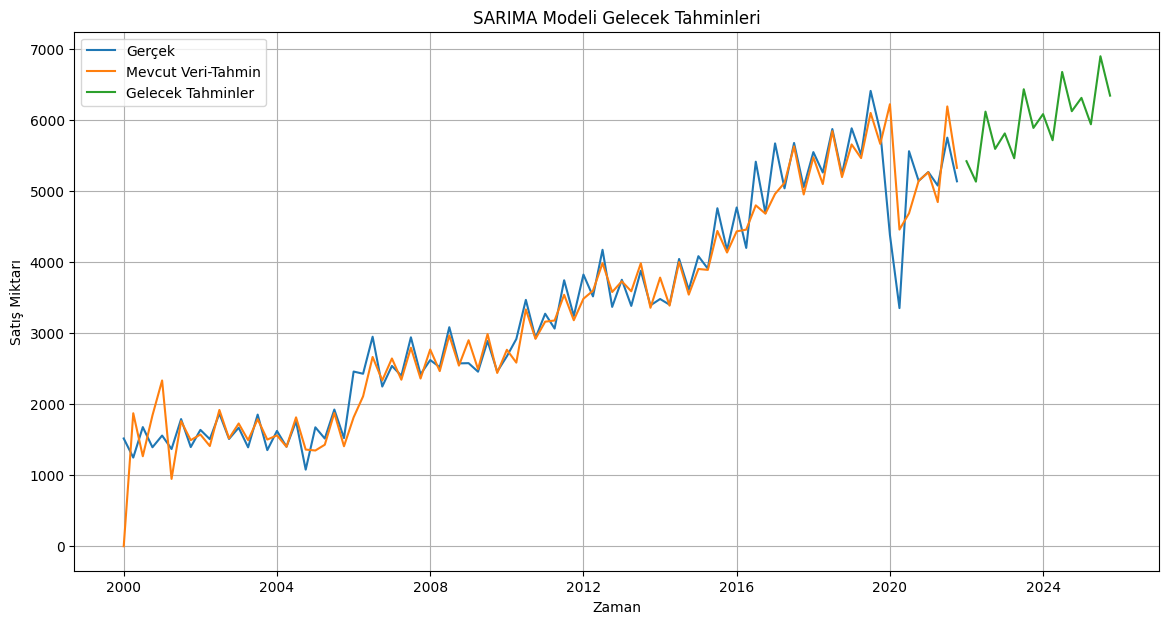

In [18]:
# gelecek 4  çeyreğe ilişkin tahminler
import numpy as np
forecast=sarima_result.get_forecast(steps=16)
mean_forecast=forecast.predicted_mean
conf_int=forecast.conf_int()
#güven aralığı değerlerini numpy dizisine çevir
lower_series=np.array(conf_int.iloc[:,0]) # tüm satırları ve ilk sütun
upper_series=np.array(conf_int.iloc[:,1]) # tüm satırları ve ilk sütun

# grafik yeniden
plt.figure(figsize=(14,7))

#gerçek değerler
plt.plot(df.index,df['Revenue'], label='Gerçek')

# Modelin tahminleri predictive
plt.plot(df.index, df['Forecast'], label="Mevcut Veri-Tahmin")

#gelecek tahmini
future_dates=pd.date_range(
    start=df.index[-1] + pd.offsets.QuarterBegin(),
    periods=16,
    freq='Q'
)

plt.plot(future_dates,mean_forecast, label="Gelecek Tahminler")

plt.title("SARIMA Modeli Gelecek Tahminleri")
plt.xlabel('Zaman')
plt.ylabel('Satış Miktarı')
plt.legend()
plt.grid(True)
plt.show()
